In [1]:
import os
os.chdir("..")


In [156]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from numerics.utilities.misc import *
import matplotlib
from scipy.linalg import solve_continuous_are
import pickle
from tqdm import tqdm
from analysis.misc import *
from scipy.special import erf

params, exp_path = def_params(flip = 0)

which = mode = give_model()
if which == "mechanical_damp":
    total_time = 4.
    dt = 1e-5
elif which == "mechanical_freq":
    omega = .5*(params[1][1] + params[0][1])
    T_param = 150.
    ppg = 1e3
    period = 2*np.pi/omega
    total_time = T_param*period
    dt = period/ppg
elif (which == "optical_homodyne") or (which == "optical_heterodyne"):
    damping = params[1][0]
    total_time = 200.*damping
    dt = damping/1e3

timind, indis, indis_range = get_timind_indis(total_time, dt, rrange=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=1, total_time=total_time, dt=dt)

In [158]:
alerr = np.zeros(len(timind))
beterr = np.zeros(len(timind))

#bbs = boundsB[80:120][::4]

bbs = np.linspace(0,6,25)
N = 5000

stop0err = np.zeros((len(timind),len(bbs)))
stop1err = np.zeros((len(timind),len(bbs)))

mstop0err = np.zeros((N,len(bbs)))
mstop1err = np.zeros((N,len(bbs)))

Sbeta = np.zeros((len(bbs)))
Salpha = np.zeros((len(bbs)))


tbeta = {indb:[] for indb in range(len(bbs))}
talpha = {indb:[] for indb in range(len(bbs))}


l0 = np.zeros(len(timind))
l1 = np.zeros(len(timind))
n=1
m10=0
m01=0
mmstops0 = [[] for indb,b in enumerate(bbs)]
mmstops1 = [[] for indb,b in enumerate(bbs)]

for itraj in tqdm(range(1,N)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)
        beterr += ((log_lik_ratio[indis_range] < 0).astype(int) - beterr)/n
        alerr += ((log_lik_ratio_swap[indis_range] >= 0).astype(int) - alerr)/n
        l1 += (log_lik_ratio -l1)/n
        l0 += (log_lik_ratio_swap -l0)/n
        for indb,b in enumerate(bbs):

            f1 = np.logical_or(log_lik_ratio[indis_range] > b, log_lik_ratio[indis_range] < -b).astype(int)
            f0 = np.logical_or(log_lik_ratio_swap[indis_range] > b, log_lik_ratio_swap[indis_range] < -b).astype(int)
            stop1err[:,indb] += (f1 - stop1err[:,indb])/n
            stop0err[:,indb] += (f0 - stop0err[:,indb])/n

            if np.argmin(~f1)!=0:
                mmstops0[indb].append(timind[np.argmin(~f1)])
            if np.argmin(~f0)!=0:
                mmstops1[indb].append(timind[np.argmin(~f0)])
            
            mstop1err[itraj-1,indb] = timind[np.argmin(~f1)]
            mstop0err[itraj-1,indb] = timind[np.argmin(~f0)]

            d10 = (log_lik_ratio_swap[indis_range] > b).astype(int)
            d01 = (log_lik_ratio[indis_range] < -b).astype(int)

            if np.argmin(~d01) == 0:
                m10+=1
            else:
                Salpha[indb] += (d10[np.argmin(~d10)] - Salpha[indb])/(n-m10)
            if np.argmin(~d01) == 0:
                m01+=1
            else:
                Sbeta[indb] += (d01[np.argmin(~d01)] - Sbeta[indb])/(n-m01)

            talpha[indb].append(timind[np.argmin(~d10)])
            tbeta[indb].append(timind[np.argmin(~d01)])

        n+=1
    except Exception:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:07<00:00, 687.66it/s]


106

In [159]:
np.log10(timind[-1]/dt)

5.6020599913279625

(array([ 4.22154677,  9.49848024, 10.55386694,  8.44309355,  9.49848024,
         6.33232016,  8.44309355,  5.27693347,  3.16616008,  6.33232016,
         5.27693347,  5.27693347,  5.27693347,  1.05538669,  1.05538669,
         2.11077339,  3.16616008,  2.11077339,  2.11077339,  1.05538669,
         0.        ,  3.16616008,  1.05538669,  2.11077339,  1.05538669,
         0.        ,  0.        ,  0.        ,  1.05538669,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.05538669,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.05538669]),
 array([0.00912 , 0.018144, 0.027168, 0.036192, 0.045216, 0.05424 ,
        0.063264, 0.072288, 0.081312, 0.090336, 0.09936 , 0.108384,
        0.117408, 0.126432, 0.135456, 0.14448 , 0.153504, 0.162528,
        0.171552, 0.180576, 0.1896  , 0.198624, 0.207648, 0.2166

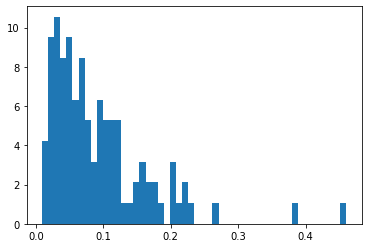

In [165]:
plt.hist(mmstops1[5], bins=50, density=True)

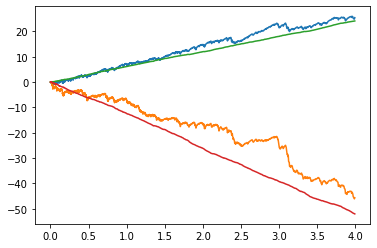

In [173]:
A = -1
plt.plot(timind[:A],log_lik_ratio[:A])
plt.plot(timind[:A],log_lik_ratio_swap[:A])
plt.plot(timind[:A],l1[:A])
plt.plot(timind[:A],l0[:A])

In [167]:
mu1=l1[-1]/timind[-1]
mu0 = l0[-1]/timind[-1]

In [168]:
alpha_err = np.array([0.5*(1 - erf(0.5*np.sqrt(t*np.abs(mu0)))) for t in timind])
beta_err = np.array([0.5*(1 - erf(0.5*np.sqrt(t*abs(mu1)))) for t in timind])

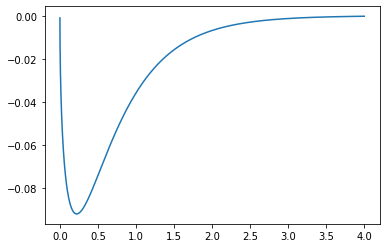

In [169]:
plt.plot(timind, alpha_err-beta_err)

Text(0.5, 0, 'Time')

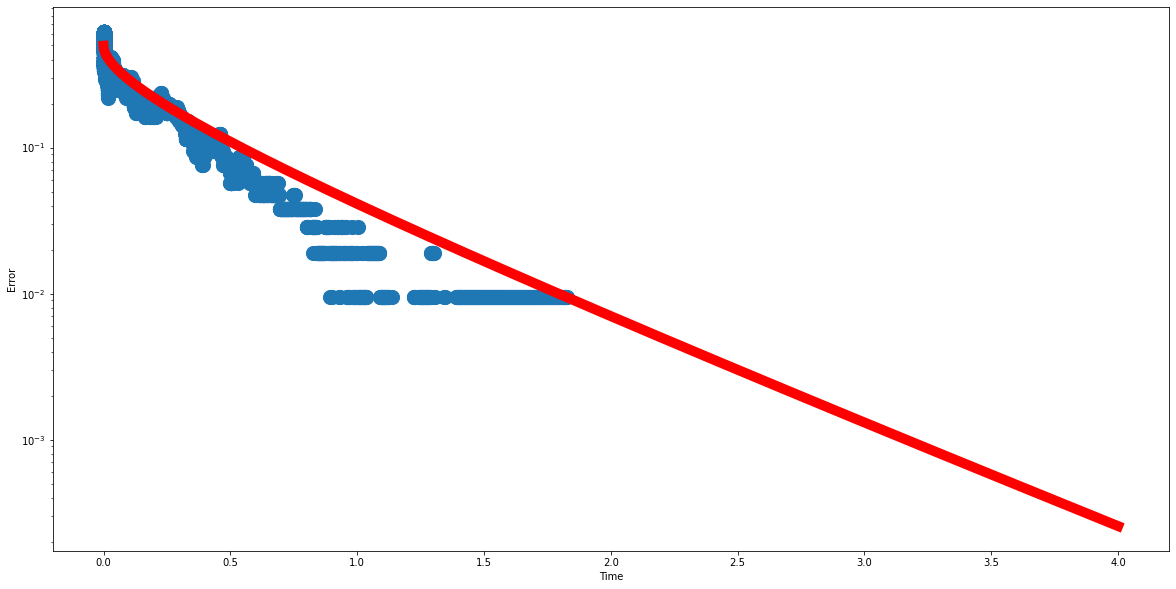

In [170]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(timind,.5*(beterr+beterr),s=200)
ax.plot(timind, .5*(beta_err + beta_err),color="red", linewidth=10)
ax.set_yscale("log")
ax.set_ylabel("Error")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

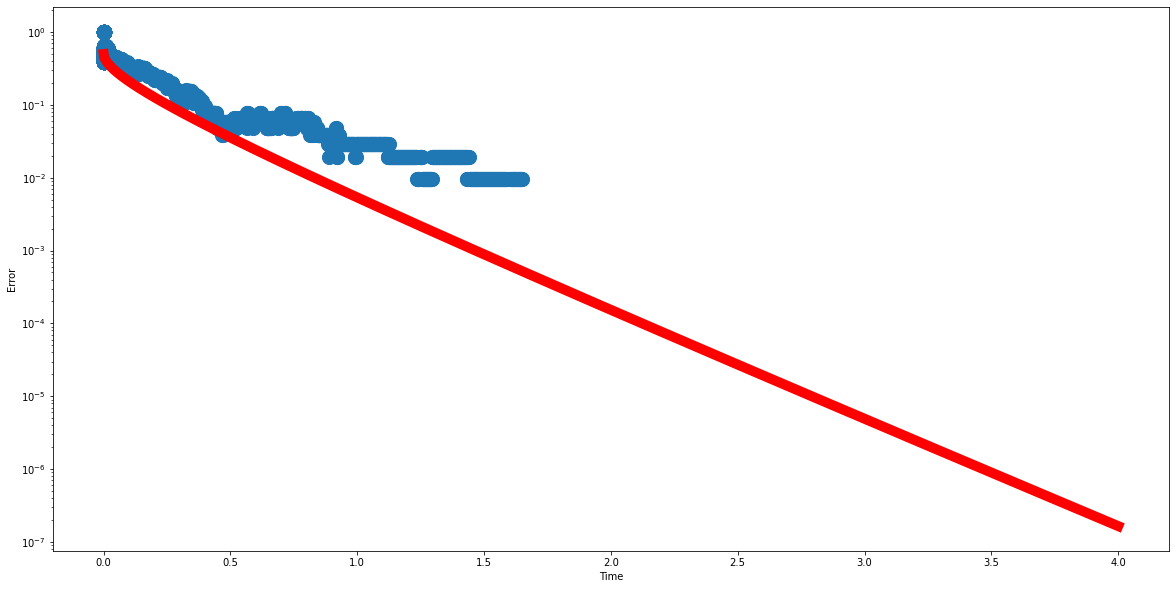

In [171]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(timind,.5*(alerr+alerr),s=200)
ax.plot(timind, .5*(alpha_err + alpha_err),color="red", linewidth=10)
ax.set_yscale("log")
ax.set_ylabel("Error")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

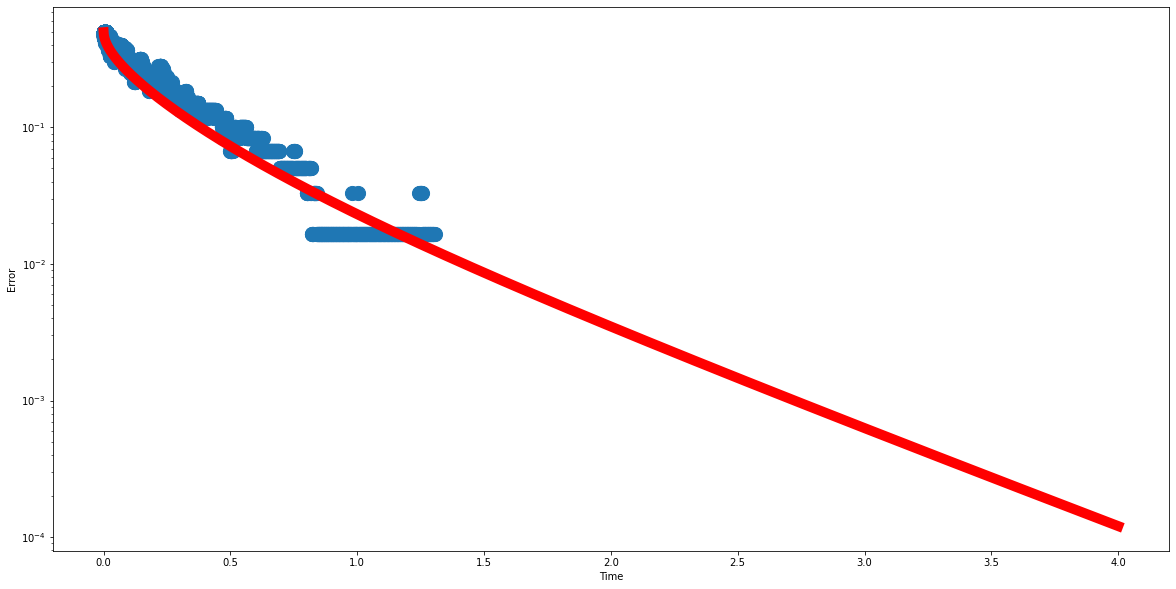

In [125]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(timind,.5*(alerr+beterr),s=200)
ax.plot(timind, .5*(alpha_err + beta_err),color="red", linewidth=10)
ax.set_yscale("log")
ax.set_ylabel("Error")
ax.set_xlabel("Time")

In [126]:
bb = np.linspace(1e-5, 10, 100)
epsilon_to_b = lambda ep: np.log((1-ep)/ep)
avg_err = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))  ###if the priors are equal this is OK

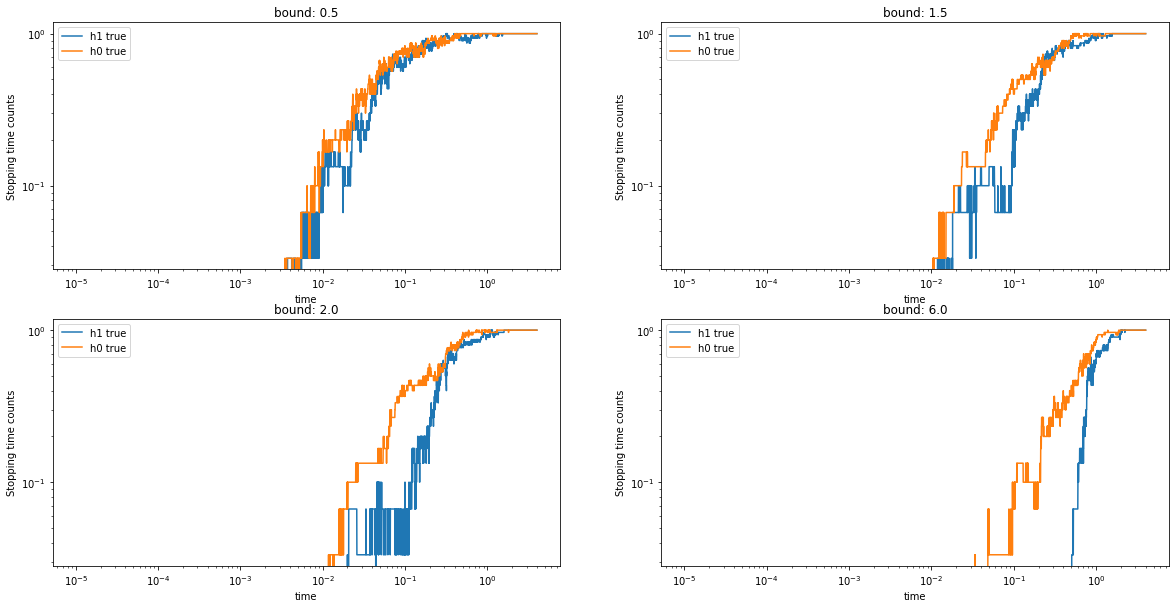

In [127]:
plt.figure(figsize=(20,10))
for k,b in enumerate([2,6,8,-1]):
    ax=plt.subplot(221+k)
    ax.set_title("bound: {}".format(np.round(bbs[b],3)))
    ax.plot(timind,stop1err[:,b], label="h1 true")
    ax.plot(timind,stop0err[:,b],label="h0 true")
    ax.set_ylabel("Stopping time counts")
    ax.set_xlabel("time")
    ax.set_yscale("log")
    ax.set_xscale("log")    
    ax.legend()

In [128]:
b_to_ep = lambda b: 1/(1+np.exp(b))
Minlogep = -np.log(b_to_ep(bbs))

alpha_err_f = lambda a, t: 0.5*(1 - erf((a - mu0*t)/np.sqrt(4*abs(mu0)*t)))
beta_err_f = lambda a, t: 0.5*(1 + erf((a - mu1*t)/np.sqrt(4*abs(mu1)*t)))

In [129]:
bb = np.linspace(min(bbs), max(bbs),100)
mean_ell = np.array(bb)*(1-avg_err(bb)) + avg_err(bb)*(-bb)

/tmp/ipykernel_3193723/2947846826.py:3: RuntimeWarning: invalid value encountered in true_divide
  avg_err = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))  ###if the priors are equal this is OK


array([[2.0000e-05, 1.8320e-02, 6.3130e-02, 1.0136e-01, 1.2111e-01,
        1.8562e-01, 1.9470e-01, 2.2179e-01, 4.6509e-01, 4.6509e-01,
        4.6750e-01, 4.9289e-01, 4.9672e-01, 4.9672e-01, 4.9736e-01,
        4.9800e-01, 4.9865e-01, 4.9865e-01, 4.9993e-01, 5.0123e-01,
        5.0252e-01, 5.0512e-01, 5.8893e-01, 5.8893e-01, 6.1614e-01],
       [2.0000e-05, 7.5000e-03, 7.8500e-03, 1.0780e-02, 1.1780e-02,
        1.4240e-02, 1.5020e-02, 1.5630e-02, 1.5770e-02, 1.8040e-02,
        1.8340e-02, 1.9060e-02, 1.9970e-02, 2.0840e-02, 2.1060e-02,
        2.1220e-02, 2.3650e-02, 2.4110e-02, 2.4300e-02, 2.4810e-02,
        2.4900e-02, 2.7330e-02, 3.1900e-02, 3.2900e-02, 3.3680e-02],
       [2.0000e-05, 5.1300e-03, 5.4400e-03, 9.1000e-03, 2.1860e-02,
        2.3530e-02, 2.3740e-02, 2.3960e-02, 2.5220e-02, 2.6730e-02,
        2.7570e-02, 2.8110e-02, 3.0930e-02, 3.1290e-02, 3.3200e-02,
        4.9920e-02, 5.0050e-02, 5.0430e-02, 5.2360e-02, 5.2700e-02,
        3.9126e-01, 3.9176e-01, 6.0667e-01, 6.

Text(0, 0.5, '$\\langle t \\rangle$')

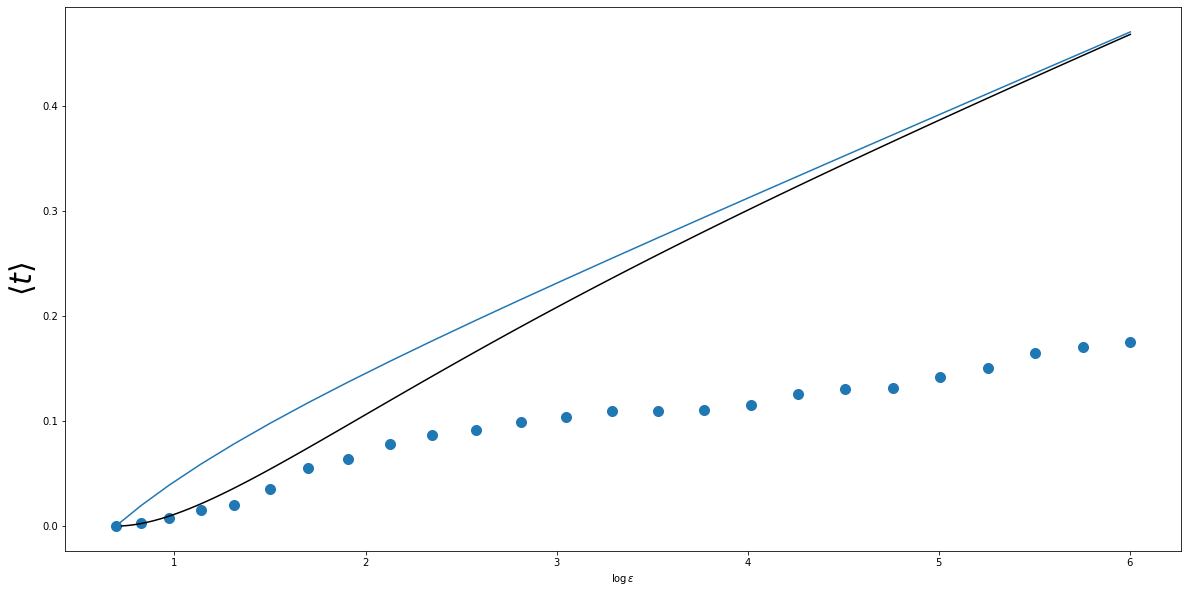

In [140]:
plt.figure(figsize=(20,10))
ax=plt.subplot(111)
ax.scatter(Minlogep,np.mean(mstop0err[:n,:],axis=0),s=100)
ax.plot(Minlogep, bbs/abs(mu0))
ax.plot(-np.log(b_to_ep(bb)), mean_ell/abs(mu0), color="black")
ax.set_xlabel(r'$\log \epsilon$')
ax.set_ylabel(r'$\langle t \rangle$',size=30)

Text(0, 0.5, '$\\langle t \\rangle$')

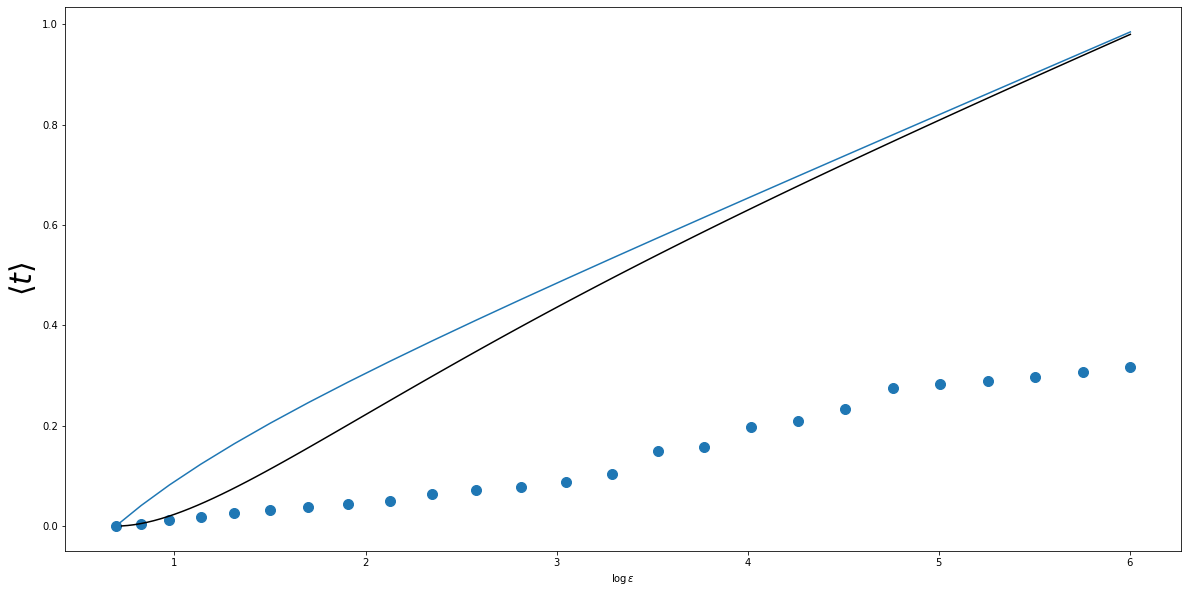

In [134]:
plt.figure(figsize=(20,10))
ax=plt.subplot(111)
ax.scatter(Minlogep,np.mean(mstop1err[:n,:],axis=0),s=100)
ax.plot(Minlogep, bbs/abs(mu1))
ax.plot(-np.log(b_to_ep(bb)), mean_ell/abs(mu1), color="black")
ax.set_xlabel(r'$\log \epsilon$')
ax.set_ylabel(r'$\langle t \rangle$',size=30)

In [41]:
mtimes_seq_0 = np.mean(mstop0err,axis=0)
mtimes_seq_1 = np.mean(mstop1err,axis=0)

alpha_seq = np.array([alpha_err_f(bbs[k],mtimes_seq_0[k]) for k in range(len(bbs))])
beta_seq = np.array([beta_err_f(-bbs[k],mtimes_seq_1[k]) for k in range(len(bbs))])

In [42]:
ee = bbs*(1-beta_seq) -bbs*beta_seq

Text(0, 0.5, '$\\langle t \\rangle$')

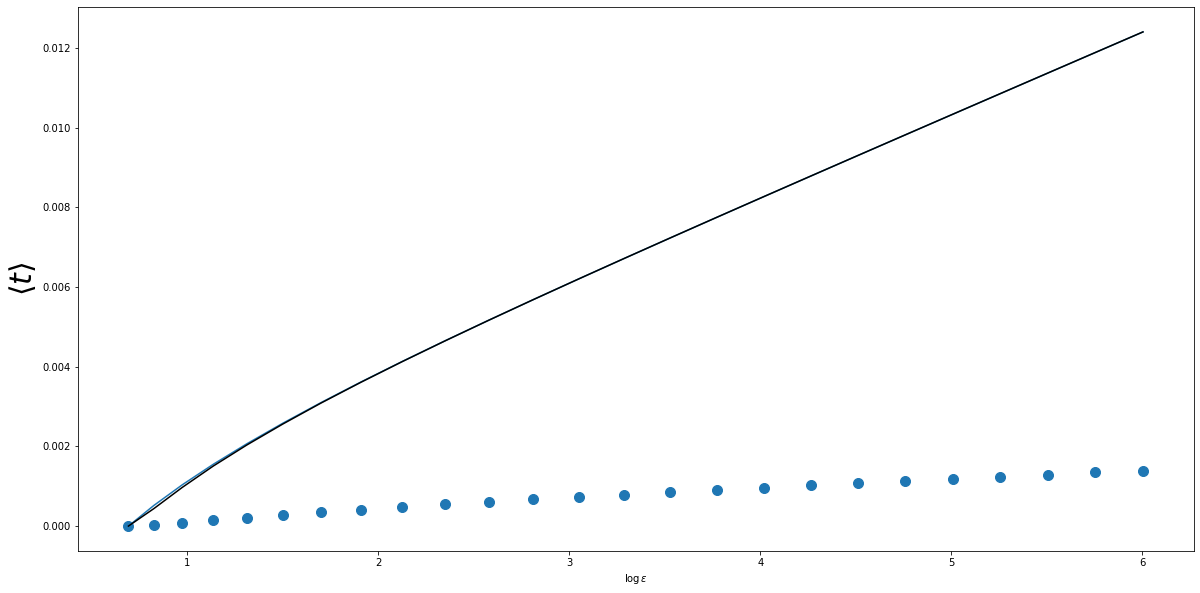

In [43]:
plt.figure(figsize=(20,10))
ax=plt.subplot(111)
ax.scatter(Minlogep,np.mean(mstop1err,axis=0),s=100)
ax.plot(Minlogep, bbs/abs(mu1))
ax.plot(-np.log(b_to_ep(bbs)), ee/abs(mu1), color="black")
ax.set_xlabel(r'$\log \epsilon$')
ax.set_ylabel(r'$\langle t \rangle$',size=30)

(array([2.53415454e+03, 7.27883539e+00, 6.15901456e+00, 5.03919373e+00,
        8.95856663e+00, 2.63157895e+01, 2.51959686e+01, 2.01567749e+01,
        1.90369541e+01, 2.63157895e+01, 1.39977604e+01, 1.67973124e+01,
        1.00783875e+01, 1.51175812e+01, 7.27883539e+00, 9.51847704e+00,
        8.95856663e+00, 2.23964166e+00, 1.23180291e+01, 7.27883539e+00,
        1.67973124e+00, 3.35946249e+00, 3.35946249e+00, 1.11982083e+00,
        1.11982083e+00, 1.67973124e+00, 5.59910414e-01, 5.59910414e-01,
        1.11982083e+00, 0.00000000e+00, 1.11982083e+00, 5.59910414e-01,
        5.59910414e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.59910414e-01]),
 array([0.       , 0.0003572, 0.0007144, 0.0010716, 0.0014288, 0.001786 ,
        0.0021432, 0

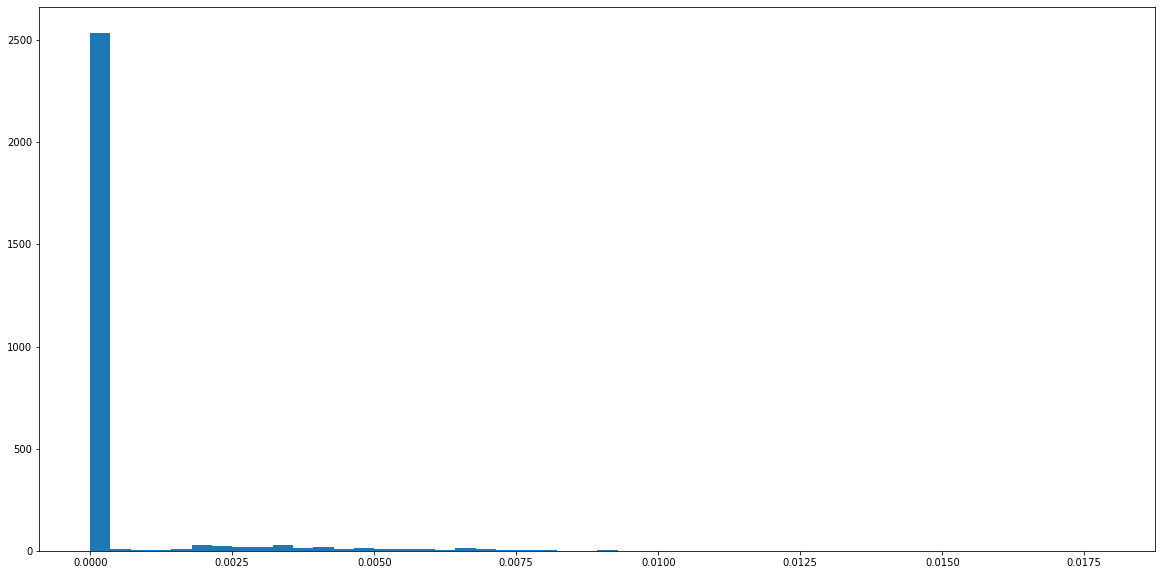

In [62]:
def prob_craft(t, b, mu):
    S= np.sqrt(2*mu)
    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

plt.figure(figsize=(20,10))
c,b = np.histogram(mstop0err[:,5], bins=50, density=True)
#plt.plot(timind,[prob_craft(t, bbs[-1], np.abs(mu0)) for t in timind])
#plt.plot(b[:-1],c)
plt.hist(mstop0err[:,5], bins=50, density=True)

In [45]:
n=1
M=int(5*1e3)
ll1 = []
ll0 = []
for itraj in tqdm(range(1,M)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)
        ll1.append(log_lik_ratio)
        ll0.append(log_lik_ratio_swap)    
    except Exception:
        pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 7162.76it/s]


In [46]:
ll1 = np.stack(ll1)
ll0 = np.stack(ll0)

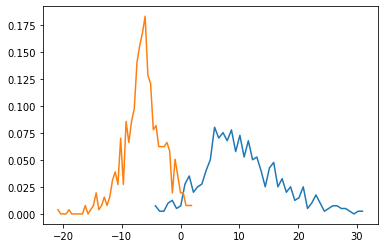

In [92]:
II= 2500
c1, b1 = np.histogram(ll1[:,-II],bins=50, density=True)
c0, b0 = np.histogram(ll0[:,-II],bins=50, density=True)

ax=plt.subplot(111)
ax.plot(b1[:-1], c1)
ax.plot(b0[:-1], c0)


In [96]:
np.mean(c1*(b1[1]-b1[0]))

0.020000000000000004

In [98]:
mu1

483.65596453773856

In [93]:
timind[-II]

0.02281

In [ ]:
ax=plt.subplot(111)
ax.plot(b1[:-1], c1)
ax.plot(b0[:-1], c0)
ax.axvline(mu1)
ax.axvline(mu0)

In [ ]:
mtimes_seq_0 = np.mean(mstop0err,axis=0)
mtimes_seq_1 = np.mean(mstop1err,axis=0)

alpha_seq = [alpha_err_f(bbs[k],mtimes_seq_0[k]) for k in range(len(bbs))]
beta_seq = [beta_err_f(bbs[k],mtimes_seq_1[k]) for k in range(len(bbs))]

In [ ]:
def prob_craft(t, b, mu):
    S= np.sqrt(2*mu)
    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

plt.figure(figsize=(20,10))
np.hist(mstop0err[:,9], bins=50, no=True)
plt.plot(timind,[prob_craft(t, bbs[9], np.abs(mu0)) for t in timind])

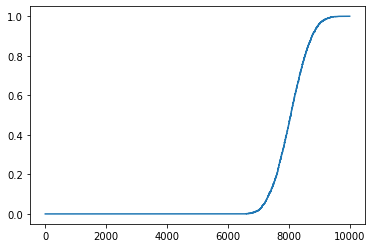

In [763]:
plt.plot(stop1err[:,-1])

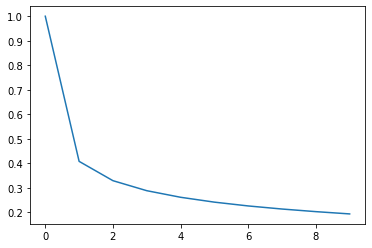

In [758]:
plt.plot(.5*(np.mean(stop0err,axis=0) +np.mean(stop1err,axis=0) ))

Text(0.5, 0, 'bound')

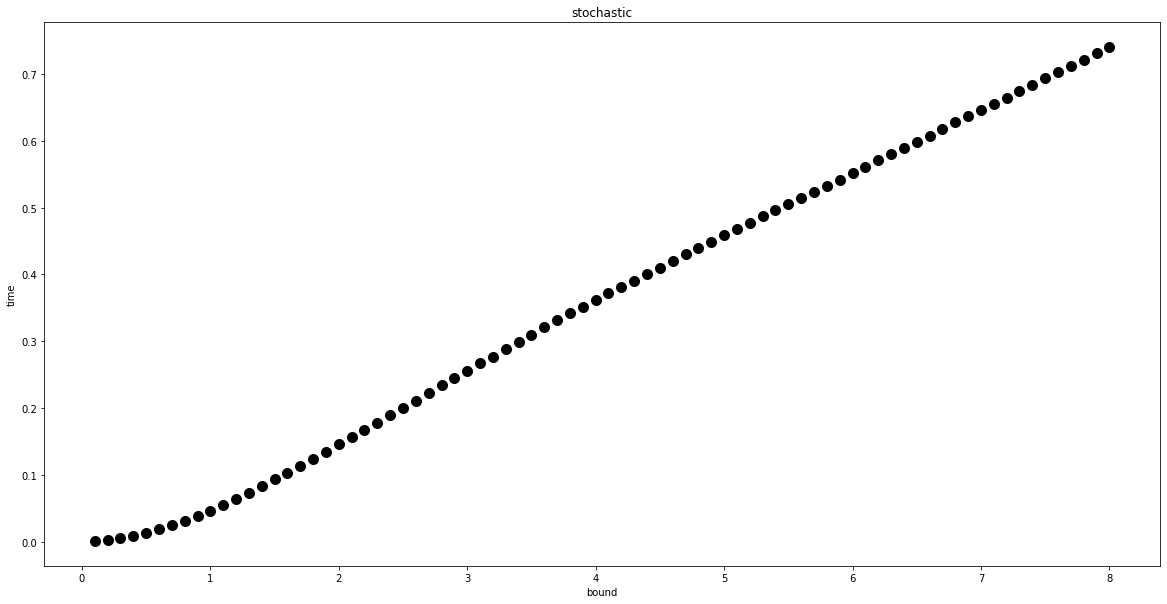

In [708]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(bpos,stoch, s=100, color="black")
ax.set_title("stochastic")
ax.set_ylabel("time")
ax.set_xlabel("bound")

In [ ]:
mean_ell = np.array(bb)*avg_err(bb) + (1-avg_err(bb))*(-bb)
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(bpos,stoch, s=100, color="black")
ax.plot(bb,bb/mu0, linewidth=5,color="blue")
ax.plot(bb,-mean_ell/mu0, '--', linewidth=5, color="red")

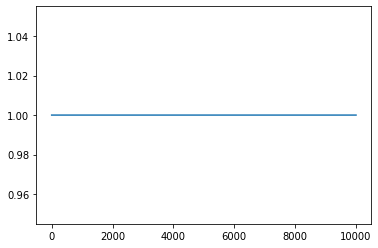

In [719]:
plt.plot(stop1err[:,0])

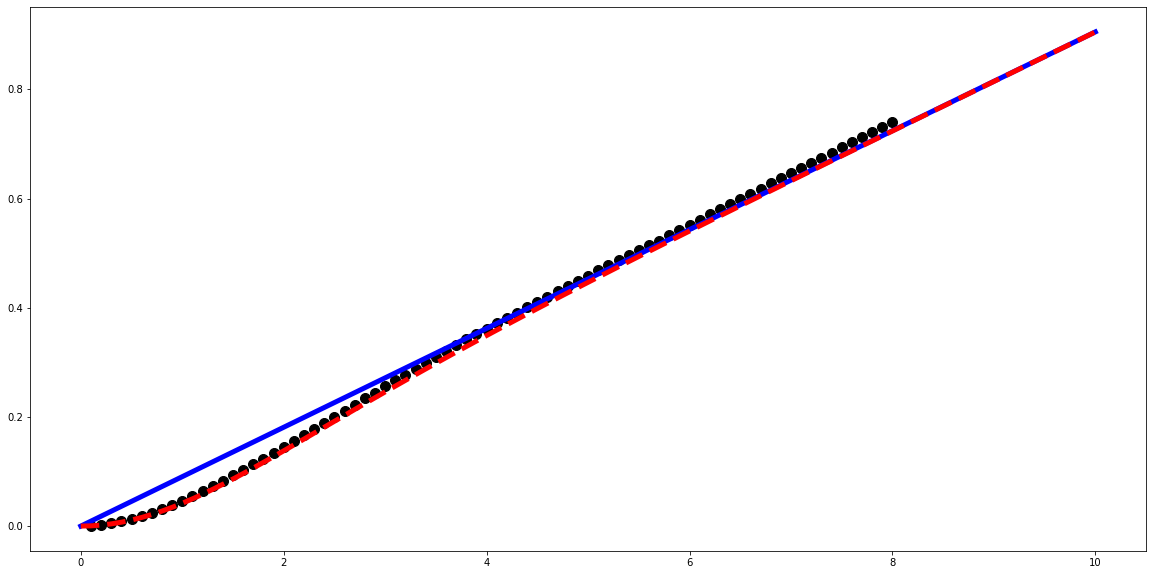

In [626]:
ll = np.array(bb)*avg_err(bb) + (1-avg_err(bb))*(-bb) # +(1-np.array(avg_err(-bpos))*np.array(bpos))
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.scatter(bpos,stoch, s=100, color="black")
ax.plot(bb,bb/mu0, linewidth=5,color="blue")
ax.plot(bb,-ll/mu0, '--', linewidth=5, color="red")

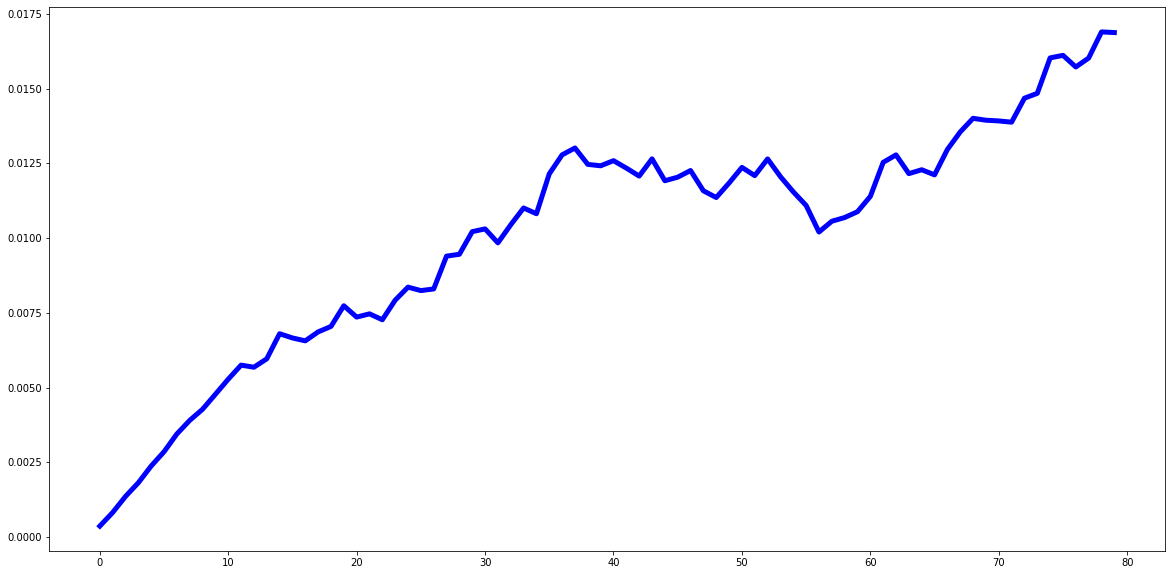

In [631]:
ll = np.array(bpos)*avg_err(bpos) + (1-avg_err(bpos))*(-bpos) # +(1-np.array(avg_err(-bpos))*np.array(bpos))
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
#ax.plot(stoch, linewidth=10, color="black")
ax.plot(stoch + ll/mu0, linewidth=5,color="blue")


ValueError: operands could not be broadcast together with shapes (80,) (100,) 

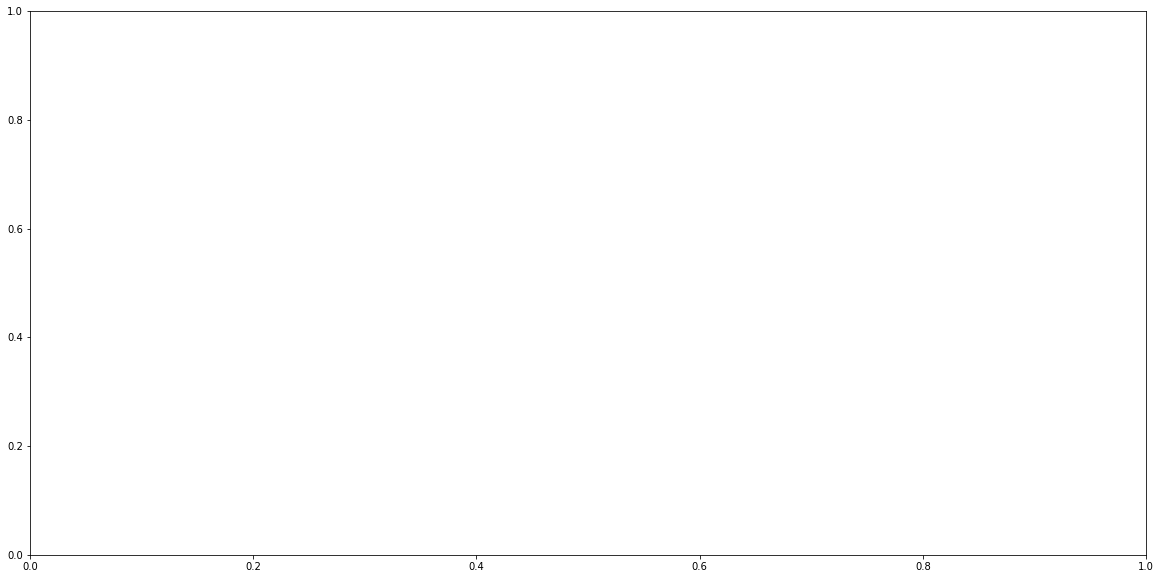

In [627]:
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
#ax.plot(stoch, linewidth=10, color="black")
ax.plot(bpos/mu + ll/mu0, linewidth=5,color="blue")


In [556]:
ta = np.mean(np.stack(list(talpha.values())), axis=1)
tb = np.mean(np.stack(list(tbeta.values())), axis=1)

In [557]:
terr = (ta + tb)/2

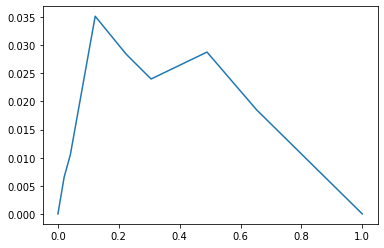

In [560]:
plt.plot(Sbeta, tb)

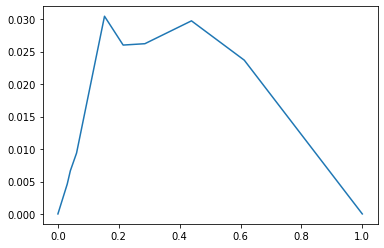

In [554]:
plt.plot(.5*(Sbeta + Salp678a), terr)

In [538]:
Salpha

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [523]:
decision[wdes]

1

In [530]:
d1[wdes]

True

In [531]:
d0[wdes]

False

In [404]:
stops = (stop0err + stop1err)/2

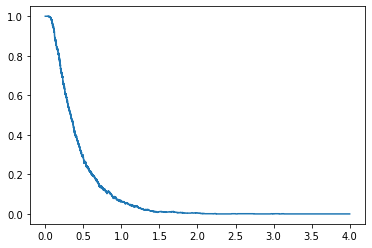

In [406]:
plt.plot(timind,1-stops[:,-1])

In [389]:
avg_err = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
grid_errs_b = np.array([avg_err(b) for b in bbs])   ### this is to compare to the fixed value of STOCH
times_stop = [timind[np.argmin(np.abs(stops[:,indb] - nb))] for indb,nb in enumerate(grid_errs_b)]

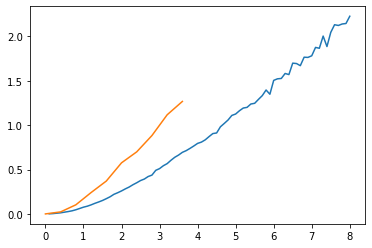

In [396]:
plt.plot(bpos,tims_det_ml)
plt.plot(bbs,times_stop)

In [364]:
avg_err = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
grid_errs_b = np.array([avg_err(b) for b in bbs])   ### this is to compare to the fixed value of STOCH
times_stop = [timind[np.argmin(np.abs(stops[:,indb] - nb))] for indb,nb in enumerate(grid_errs_b)]

In [286]:
b = 1.


array([0, 0, 0, ..., 0, 0, 0])

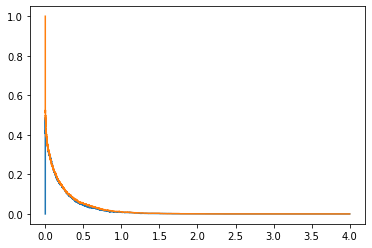

In [276]:
plt.plot(timind,alerr)
plt.plot(timind,beterr)

In [277]:
errprob = 0.5*(alerr + beterr)

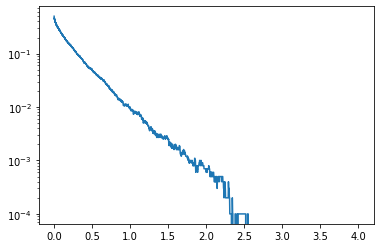

In [278]:
ax = plt.subplot(111)
ax.plot(timind,errprob)
ax.set_yscale("log")

In [279]:
errs_anal = np.array([0.5*(1 + erf(0.5*np.sqrt(t*mu))) for t in timind])

Text(0.5, 0, 'time')

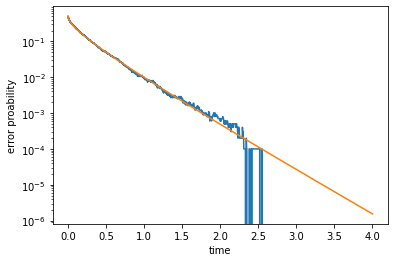

In [285]:
ax = plt.subplot(111)
ax.plot(timind,errprob, label="num")
ax.plot(timind, 1-errs_anal, label="w/ gamma")
ax.set_yscale("log")
ax.set_ylabel("error proability")
ax.set_xlabel("time")

In [281]:
where_err_meet = [np.argmin(np.abs(errprob-k)) for k in grid_errs]

In [282]:
tims_det_ml = np.array([timind[j] for j in where_err_meet])

array([0.00918974, 0.01837949, 0.02756923, 0.03675898, 0.04594872,
       0.05513847, 0.06432821, 0.07351796, 0.0827077 , 0.09189744,
       0.10108719, 0.11027693, 0.11946668, 0.12865642, 0.13784617,
       0.14703591, 0.15622565, 0.1654154 , 0.17460514, 0.18379489,
       0.19298463, 0.20217438, 0.21136412, 0.22055387, 0.22974361,
       0.23893335, 0.2481231 , 0.25731284, 0.26650259, 0.27569233,
       0.28488208, 0.29407182, 0.30326156, 0.31245131, 0.32164105,
       0.3308308 , 0.34002054, 0.34921029, 0.35840003, 0.36758978,
       0.37677952, 0.38596926, 0.39515901, 0.40434875, 0.4135385 ,
       0.42272824, 0.43191799, 0.44110773, 0.45029747, 0.45948722,
       0.46867696, 0.47786671, 0.48705645, 0.4962462 , 0.50543594,
       0.51462569, 0.52381543, 0.53300517, 0.54219492, 0.55138466,
       0.56057441, 0.56976415, 0.5789539 , 0.58814364, 0.59733339,
       0.60652313, 0.61571287, 0.62490262, 0.63409236, 0.64328211,
       0.65247185, 0.6616616 , 0.67085134, 0.68004108, 0.68923

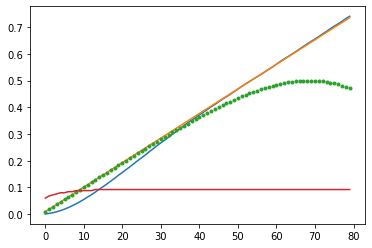

In [491]:
plt.plot(stoch)
plt.plot(bpos/mu)
plt.plot(corrs0,'.')
plt.plot(stt_num)

In [476]:
gt = np.linspace(0,timind[-1],1000)

In [494]:
stt_num = []
for a in bpos:

    corrs =np.array([.5*(1 + erf((a + mu*t)/np.sqrt(2*mu*t) -erf((-a + abs(mu0)*t)/np.sqrt(2*abs(mu0)*t))) for t in gt])/mu
    stt_num.append(gt[np.argmin(np.stack([np.abs(corrs[k]-tt) for k,tt in enumerate(gt)]))])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (1163699535.py, line 4)

In [499]:
def pro(l,mu,t):
    return np.exp(-((l - mu*t)**2)/(2*mu*t))/np.sqrt((2*np.pi*mu*t))

In [509]:
ss = []
for a in bpos:

    right = np.array([pro(a,mu,t)*a/mu for t in gt])
    sto = gt[np.argmin(np.abs(right - gt))]
    ss.append(sto)

/tmp/ipykernel_554926/2938199114.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-((l - mu*t)**2)/(2*mu*t))/np.sqrt((2*np.pi*mu*t))
/tmp/ipykernel_554926/2938199114.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-((l - mu*t)**2)/(2*mu*t))/np.sqrt((2*np.pi*mu*t))


/tmp/ipykernel_554926/2938199114.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-((l - mu*t)**2)/(2*mu*t))/np.sqrt((2*np.pi*mu*t))
/tmp/ipykernel_554926/2938199114.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-((l - mu*t)**2)/(2*mu*t))/np.sqrt((2*np.pi*mu*t))


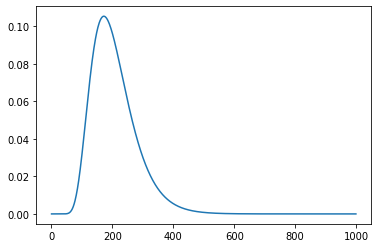

In [512]:
plt.plot([pro(a,mu,t)*a/mu for t in gt])

0.0

In [496]:
erf((a + mu*t)/np.sqrt(2*mu*t))

NameError: name 't' is not defined

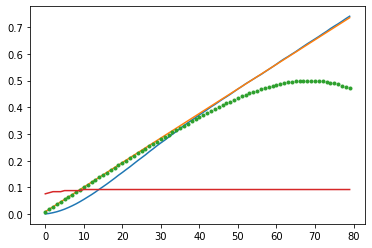

In [493]:
plt.plot(stoch)
plt.plot(bpos/mu)
plt.plot(corrs0,'.')
plt.plot(stt_num)

In [436]:
mu1 = l1[-1]/timind[-1]
mu0 = l0[-1]/timind[-1]

In [447]:
corrs =np.array([erf((a + mu)/np.sqrt(2*mu)) for a in bpos])

In [464]:
corrs0 =np.array([erf((-a + np.abs(mu0))/np.sqrt(2*np.abs(mu0))) for a in bpos])

In [465]:
corrs = corrs*bpos/mu

In [466]:
corrs0 = corrs0*bpos/mu

In [467]:
corrs0

array([0.00918065, 0.01835926, 0.02753551, 0.03670904, 0.04587945,
       0.05504631, 0.0642091 , 0.07336729, 0.08252024, 0.09166729,
       0.10080767, 0.10994056, 0.11906503, 0.12818006, 0.13728456,
       0.1463773 , 0.15545694, 0.16452202, 0.17357096, 0.18260202,
       0.1916133 , 0.20060278, 0.20956822, 0.21850722, 0.22741719,
       0.23629534, 0.24513864, 0.25394385, 0.2627075 , 0.27142585,
       0.28009492, 0.28871043, 0.29726784, 0.30576229, 0.31418863,
       0.32254138, 0.33081473, 0.33900254, 0.34709832, 0.35509519,
       0.36298595, 0.37076298, 0.37841831, 0.38594356, 0.39332998,
       0.40056841, 0.4076493 , 0.41456268, 0.4212982 , 0.42784513,
       0.43419233, 0.44032826, 0.44624104, 0.45191841, 0.45734773,
       0.46251605, 0.46741009, 0.47201625, 0.47632065, 0.48030917,
       0.48396742, 0.48728082, 0.49023461, 0.49281388, 0.49500361,
       0.4967887 , 0.49815401, 0.49908443, 0.49956487, 0.49958035,
       0.49911601, 0.49815719, 0.49668947, 0.49469871, 0.49217

/tmp/ipykernel_554926/2013439416.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((tims_det_ml[-1:] -tims_det_ml[1:]) /np.array((stoch[-1:]-stoch[1:])))


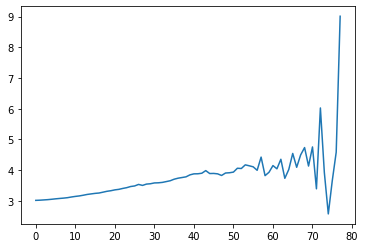

In [284]:
plt.plot((tims_det_ml[-1:] -tims_det_ml[1:]) /np.array((stoch[-1:]-stoch[1:])))

In [209]:
avg_err = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
grid_errs = np.array([avg_err(b) for b in bpos])   ### this is to compare to the fixed value of STOCH

In [225]:
grid_errs

array([4.75020813e-01, 4.50166003e-01, 4.25557483e-01, 4.01312340e-01,
       3.77540669e-01, 3.54343694e-01, 3.31812228e-01, 3.10025519e-01,
       2.89050497e-01, 2.68941421e-01, 2.49739894e-01, 2.31475217e-01,
       2.14165017e-01, 1.97816111e-01, 1.82425524e-01, 1.67981615e-01,
       1.54465265e-01, 1.41851065e-01, 1.30108474e-01, 1.19202922e-01,
       1.09096821e-01, 9.97504891e-02, 9.11229610e-02, 8.31726965e-02,
       7.58581800e-02, 6.91384203e-02, 6.29733561e-02, 5.73241759e-02,
       5.21535631e-02, 4.74258732e-02, 4.31072549e-02, 3.91657228e-02,
       3.55711893e-02, 3.22954647e-02, 2.93122308e-02, 2.65969936e-02,
       2.41270214e-02, 2.18812709e-02, 1.98403057e-02, 1.79862100e-02,
       1.63024994e-02, 1.47740317e-02, 1.33869178e-02, 1.21284350e-02,
       1.09869426e-02, 9.95180187e-03, 9.01329865e-03, 8.16257115e-03,
       7.39154134e-03, 6.69285092e-03, 6.05980149e-03, 5.48629890e-03,
       4.96680165e-03, 4.49627316e-03, 4.07013772e-03, 3.68423990e-03,
      

In [215]:
np.argnp.abs(grid_errs - errprob)

ValueError: operands could not be broadcast together with shapes (161,) (10000,) 

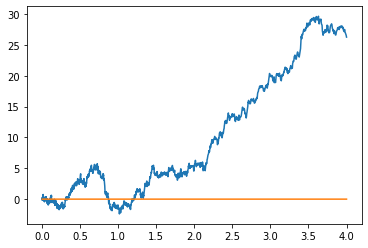

In [185]:
plt.plot(timind,log_lik_ratio)
plt.plot(timind, np.zeros(len(timind)))

In [180]:
len(indis_range)

10000

In [181]:
len(log_lik_ratio)

10000

In [21]:
mu, _ = np.polyfit(timind[:-100], l1[:-100],1)


In [22]:
mu

10.881695484234605

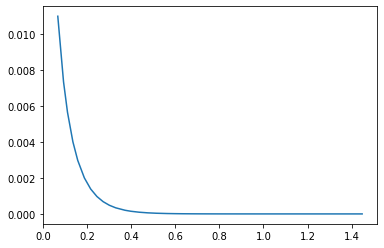

In [35]:
plt.plot(times_alpha_to_errB[A:B], -1*np.log(errs)/mu)

In [26]:
-np.log(erf(np.sqrt(mu)*times_alpha_to_errB[A:B]))

array([1.39757878e+00, 1.08607890e+00, 9.23613857e-01, 7.45961109e-01,
       6.18270742e-01, 4.78660198e-01, 3.74037227e-01, 2.91896116e-01,
       2.26686269e-01, 1.74479361e-01, 1.32041983e-01, 8.57979933e-02,
       6.48113136e-02, 4.28379213e-02, 2.69277640e-02, 1.65576739e-02,
       8.50071262e-03, 5.16271488e-03, 3.18818292e-03, 1.48082665e-03,
       8.69671208e-04, 4.70589636e-04, 2.22744075e-04, 1.14669274e-04,
       4.35463251e-05, 1.85085483e-05, 7.46714723e-06, 3.50573628e-06,
       1.42283019e-06, 3.00478052e-07, 9.34113999e-08, 3.50600319e-08,
       7.63984767e-09, 1.83361548e-09, 3.91970345e-10, 1.03143161e-10,
       1.45798928e-11])

In [3]:
B = 8.
dB = .1
boundsB= np.arange(-B,B+dB,dB)
bpos = boundsB[boundsB>=0]

In [4]:
Ntraj = 5000

In [5]:
path_data = get_def_path()+"analysis/{}/".format(Ntraj,mode)


In [17]:
from scipy.special import erf

In [95]:
errs = 1-0.5*(1 + erf(0.5*np.sqrt(mu*times_alpha_to_errB[A:B])))

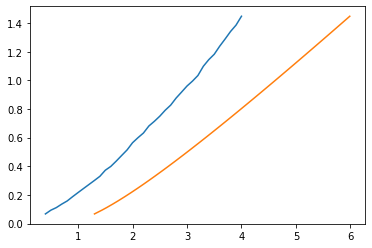

In [96]:
plt.plot(bpos[A:B],times_alpha_to_errB[A:B])
plt.plot( -np.log(errs), times_alpha_to_errB[A:B])

In [163]:
alphas = vals_h0_h1 = np.stack(list(deter["h0/h1"].values()))
betas = vals_h1_h0 = np.stack(list(deter["h1/h0"].values()))

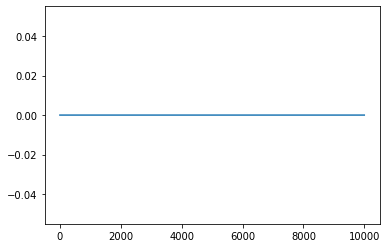

In [174]:
plt.plot(alphas[80,:])

In [175]:
boundsB[80]

-2.842170943040401e-14

In [ ]:
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)

In [147]:
avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in bpos]) #
tot_err = 0.5*(alphas+betas)

times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]

In [149]:
tot_err.shape

(161, 10000)

In [151]:
np.argmin(np.abs(boundsB))

80

In [160]:
alphas[80]

array([0., 0., 0., ..., 0., 0., 0.])

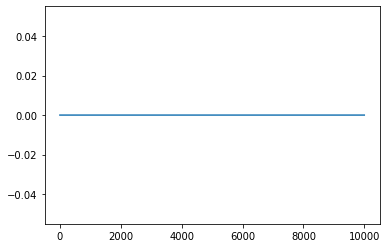

In [157]:
plt.plot(betas[80,:])

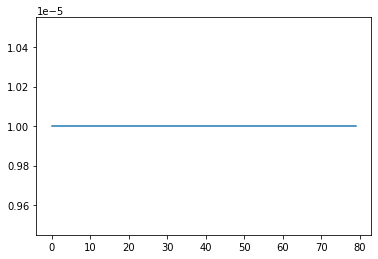

In [144]:
plt.plot(times_to_errs)

In [122]:
np.argmin(np.abs(bpos-1))

9

In [ ]:
np.stack(list(deter["h0/h1"].values())).shape

/tmp/ipykernel_554926/2292628644.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(bpos[A:B][1:], dd/ss)


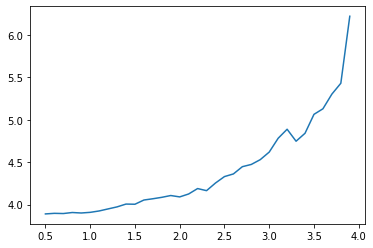

In [48]:
dd = times_alpha_to_errB[A:B][-1:]-times_alpha_to_errB[A:B][1:]
ss = stoch[A:B][-1:] - stoch[A:B][1:]
plt.plot(bpos[A:B][1:], dd/ss)

Text(0, 0.5, '$\\frac{t_d}{t_s}}$')

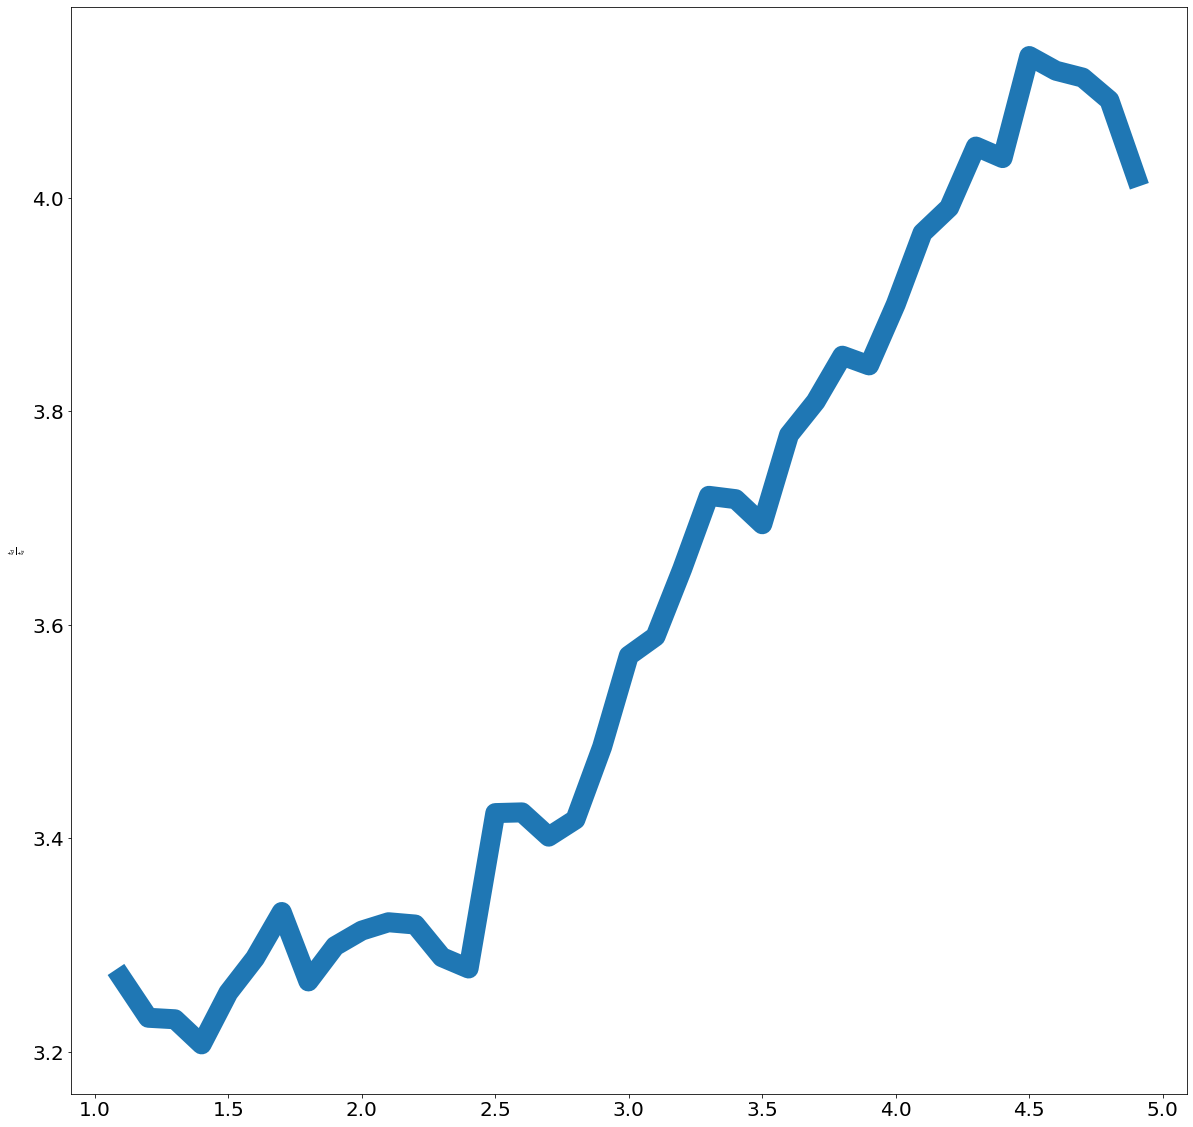

In [45]:
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
LW = 20
ax.plot(bpos[10:49],(times_alpha_to_errB/stoch)[10:49], linewidth=LW)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel(r'$\frac{t_d}{t_s}}$')

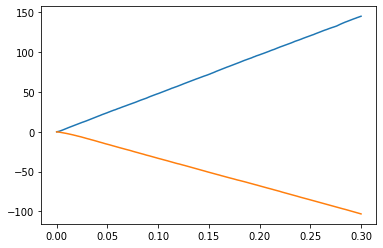

In [51]:
plt.plot(timind,l1)
plt.plot(timind,l0)

/tmp/ipykernel_511818/2059129522.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div
/tmp/ipykernel_511818/2059129522.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div


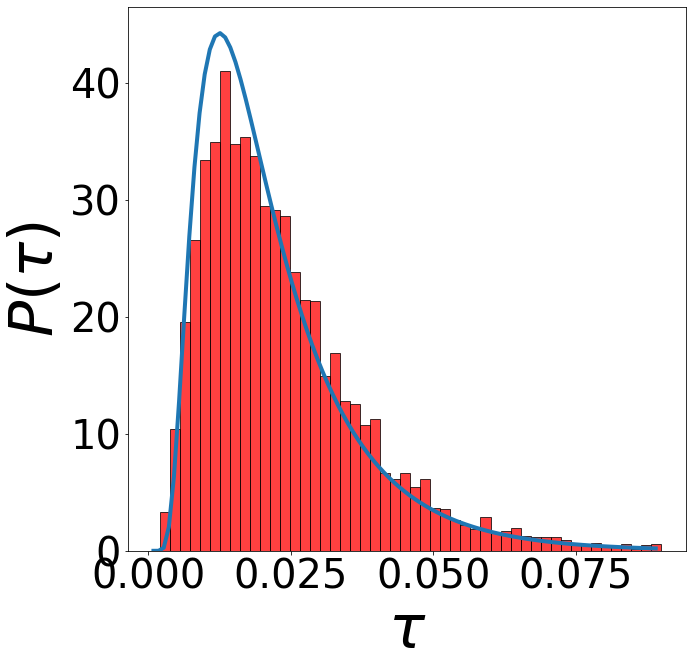

In [36]:
def prob_craft(t, b, mu):
    S= np.sqrt(2*mu)
    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

muu, _ = np.polyfit(timind, l1,1)

LS, TS = 60, 40
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
indb = 49

# timm =  np.linspace(np.min(timbin1[indb]),np.max(timbin1[indb]),100)
timm =  np.linspace(0,np.max(timbin1[indb]),100)

popo = [prob_craft(tt, bpos[indb] , muu) for tt in timm]
ax.plot(timm,popo, linewidth=4)
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [35]:
np.argmin(np.abs(bpos-5))

49

In [32]:
bpos

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. ])